## Import libs and custom vars

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from libs.utils import return_outcome, fix_continent_matches
from matplotlib import pyplot as plt
import datetime
from numba import jit

<b>L'obbiettivo del progetto è la costruzione di un modello per predizioni di match internazionali</b>


<ul>
    <li>Ci sono alcuni nomi di squadre che sono cambiate nel tempo, uniformizza </li>
    <li>Shootouts è il db dei penalty, quindi bisogna manipolare il dataset per vedere chi vince alla fine quella partita</li>
</ul>

### Descrizione del dataset


Il Dataset contiene 42483 risultati di partite di calcio internazionale maschile. In particolare, sono incluse sia le partite ufficiali di tutte le competizioni: dalle amichevoli alla coppa del mondo eccetto i Giochi Olimpici o le partite dove almeno una delle due squadre era la squadra B o U-23. Inoltre, il dataset presenta un ulteriore file che contiene 432 risultati di partite terminate con i calci di rigore, <u>che non considereremo in quanto il modello dovrà predirre il risultato come: 'Home win', 'Draw', 'Away win'.</u>

In [2]:
dst_df = pd.read_csv('dataset/results.csv');

print("Null values:", dst_df.isnull().values.any(), "| shape:", dst_df.shape)
print("***"*15)
print(dst_df.info())

Null values: False | shape: (42483, 9)
*********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42483 entries, 0 to 42482
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        42483 non-null  object
 1   home_team   42483 non-null  object
 2   away_team   42483 non-null  object
 3   home_score  42483 non-null  int64 
 4   away_score  42483 non-null  int64 
 5   tournament  42483 non-null  object
 6   city        42483 non-null  object
 7   country     42483 non-null  object
 8   neutral     42483 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.6+ MB
None


### Preparazione del daset

- campo date formattato in anno
- colonna 'risultato'
- converto home_score e away_score in float

In [3]:
dst_df = dst_df.astype({"home_score": float, "away_score": float})

dst_df['outcome'] = None
dst_df['day'] = None
dst_df['month'] = None
dst_df['year'] = None

date_separator = ', '

counter = 0
for i in range(0, len(dst_df)):
    counter = counter + 1
    print('*** Processing %d/%d ***' % (counter, len(dst_df)), end='\r')

    # Formatto i nomi dei continenti per standardizzarli al dataset FIFA usato dopo
    if(dst_df.loc[i]['country'] == 'United States'):
        dst_df.at[i, 'country'] = 'USA'

    # estraggo dati necessari dalla data
    row_date = datetime.date.fromisoformat(dst_df.iloc[i]['date'])
    dst_df.at[i, 'day'] = row_date.strftime('%d') + date_separator + row_date.strftime('%A')
    dst_df.at[i, 'month'] = row_date.strftime('%B')
    dst_df.at[i, 'year'] = int(row_date.strftime('%Y'))

    # calcolo il risultato della partita
    dst_df.at[i, 'outcome'] = return_outcome(dst_df.iloc[i]['home_score'], dst_df.iloc[i]['away_score'])

    # deprecato
    # if(dst_df.iloc[i]['outcome'] == 'D'):
    #     dst_df.at[i, 'outcome'] = find_penalty(data['results'].iloc[i], data['shootouts'], sht_len - 1)

dst_df.drop(labels=['date'], axis=1, inplace=True)
dst_df.to_csv('dataset/dataset.csv')

### To do:
Da vedere come inserire:
- comparare il numero di partite per nazione
- score per games?

Modelli:
    - Regressione logistica
    - Alberi decisionali
    - o...?

Da inserire (?)
    - FIFa ranking per elaborazione modello
        - regole del ranking
        - spiegare funzionamento
        - aggiungere 'ranking' in base alla data
    
Aggiuntivi da implementare via facendo + descrizione
- Eliminare i paesi che hanno cambiato nome/pulizia dataset
- Riduzione delle dimensionalità
    - per il calcolo del modello considera solo se le partite sono state giocate in campo neutrale

In [4]:
dst = pd.read_csv('dataset/dataset.csv')
dst.drop(labels=['Unnamed: 0', 'city'], axis=1, inplace=True)

dst.head()

,home_team,away_team,home_score,away_score,tournament,country,neutral,outcome,day,month,year
0,Scotland,England,0.0,0.0,Friendly,Scotland,False,Draw,"30, Saturday",November,1872
1,England,Scotland,4.0,2.0,Friendly,England,False,Home,"08, Saturday",March,1873
2,Scotland,England,2.0,1.0,Friendly,Scotland,False,Home,"07, Saturday",March,1874
3,England,Scotland,2.0,2.0,Friendly,England,False,Draw,"06, Saturday",March,1875
4,Scotland,England,3.0,0.0,Friendly,Scotland,False,Home,"04, Saturday",March,1876


### 1. Statistica descrittiva - Distribuzione dei dati

Descrizione del dataset
1. <s>Numero di partie per anno</s>
2. <s>Numero di partie per anno per contiente</s>
    - Approssimazione a CMF/PMF ???
3. Numero di squadre per continente
4. Numero di goal per anno (? / scatterplot)

    - Migliore team (per attacco e difesa) per decade
    - Distribuizione di goal con boxplot/scatterplot (Football most progressive countries)

5. Numero di vittorie (scatterplot)

Scatterplot draw, home win away win


##### Numero di partite per anno:

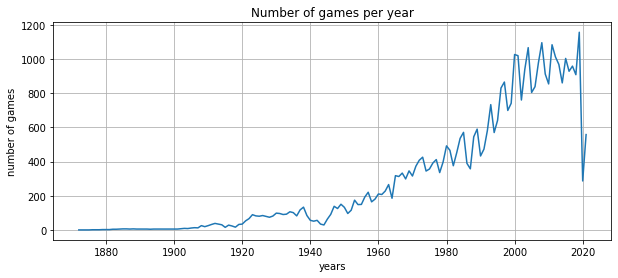

In [5]:
#### inserire prima guerra mondiale, seconda e covid

mpy = dst['year'].value_counts().sort_index()

plt.figure(figsize=(10,4))
plt.title(label='Number of games per year')
plt.ylabel(ylabel='number of games')
plt.xlabel(xlabel='years')
plt.plot(mpy)

plt.grid()
plt.show()

##### Numero di partite giocate per anno da ogni continente

In [3]:
# continente in cui è stato disputato il match
dst['continent'] = ''

# mi ricavo le confederazioni delle nazionali dal dataset FIFA
dst_fifa = pd.read_csv('dataset/fifa_ranking-2021-05-27.csv')
dst_fifa.drop(labels=['rank', 'rank_date', 'rank_change', 'total_points', 'previous_points', 'id'], axis=1, inplace=True)
dst_fifa.drop_duplicates(subset="country_full", keep="first", inplace=True)

# so già a prescindere che ci saranno delle nazioni non riconosciute
df_nocontinent_found = pd.DataFrame(columns=dst.columns)

index_mismatches_dst = []

for i in range(0, len(dst)):
    if( dst_fifa[(dst_fifa.country_full == dst.iloc[i]['country'])]['confederation'].values.__len__() == 1 ):
        confederation = dst_fifa[(dst_fifa.country_full == dst.iloc[i]['country'])]['confederation'].values[0]
        
        if confederation in "CONCACAF":
            continent = "America"

        if confederation in "CONMEBOL":
            continent = "America"

        if confederation == "UEFA":
            continent = "Europe"

        if(confederation == "AFC"):
            continent = "Asia"
        
        if(confederation == "CAF"):
            continent = "Africa"

        if(confederation == "OFC"):
            continent = "Oceania"

        dst.at[i, 'continent'] = continent
    else:
            current = dst.iloc[i]['country']

            if (current == 'Bohemia'
                    or current == 'Soviet Union'
                    or current == 'Irish Free State'
                    or current == 'German DR'
                    or current == 'Saarland'
                    or current == 'Jersey'
                    or current == 'Northern Cyprus'
                    or current == 'Isle of Man'
                    or current == 'Guernsey'
                    or current == 'Bohemia and Moravia'
                    or current == 'Monaco' ):
                dst.at[i, 'continent'] = 'Europe'

            elif (dst.iloc[i]['country'] == 'British Guyana'
                    or current == 'Netherlands Guyana'
                    or current == 'French Guiana'
                    or current == 'Saint Kitts and Nevis'
                    or current == 'Éire'
                    or current == 'Guadeloupe'
                    or current == 'Martinique'
                    or current == 'Saint Lucia'
                    or current == 'Saint Vincent and the Grenadines'
                    or current == 'Saint Martin'
                    or current == 'United States Virgin Islands'
                    or current == 'Sint Maarten'
                    or current == 'Greenland' ):
                dst.at[i, 'continent'] = 'America'

            elif (dst.iloc[i]['country'] == 'Manchuria'
                    or current == 'Iran'
                    or current == 'Ceylon'
                    or current == 'Burma'
                    or current == 'Malaya'
                    or current == 'South Korea'
                    or current == 'Vietnam Republic'
                    or current == 'United Arab Republic'
                    or current == 'North Korea'
                    or current == 'Vietnam DR'
                    or current == 'Taiwan'
                    or current == 'Kyrgyzstan'
                    or current == 'East Timor'
                    or current == 'Brunei'
                    or current == 'Yemen DPR'
                    or current == 'Yemen AR' ):
                dst.at[i, 'continent'] = 'Asia'

            elif (dst.iloc[i]['country'] == 'Northern Rhodesia'
                    or current == 'Tanganyika'
                    or current == 'French Somaliland'
                    or current == 'Belgian Congo'
                    or current == 'Southern Rhodesia'
                    or current == 'Réunion'
                    or current == 'Zanzibar' 
                    or current == 'Gold Coast'
                    or current == 'Nyasaland'
                    or current == 'Dahomey'
                    or current == 'Mali Federation'
                    or current == 'Ivory Coast'
                    or current == 'DR Congo'
                    or current == 'Upper Volta'
                    or current == 'Eswatini'
                    or current == 'Zaïre'
                    or current == 'Cape Verde'
                    or current == 'Mayotte'
                    or current == 'Portuguese Guinea'
                    or current == 'Rhodesia' ):
                dst.at[i, 'continent'] = 'Africa'

            elif (dst.iloc[i]['country'] == 'French Polynesia'
                    or current == 'New Hebrides'
                    or current == 'Lautoka'
                    or current == 'Northern Mariana Islands'
                    or current == 'Micronesia'
                    or current == 'Palau'
                    or current == 'Western Samoa' ):
                dst.at[i, 'continent'] = 'Oceania'

            else:
                print("Exception at row: %d" % i)
                df_nocontinent_found = df_nocontinent_found.append(dst.iloc[i])


if(df_nocontinent_found.__len__() == 0):
    print("All rows are correctly updated")
else:
    # per analizzare meglio salvo il csv
    df_nocontinent_found.to_csv('output.csv')


# salvo per evitare di doverlo ricreare se faccio errori
dst.to_csv('dataset/dataset_continent.csv')

All rows are correctly updated


In [2]:
dst_continent_ = pd.read_csv('dataset/dataset_continent.csv')
dst_continent_.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

dst_continent_reduced = dst_continent_.groupby(['continent','year']).size().to_csv('output.csv')
dst_continent_reduced = pd.read_csv('output.csv')
dst_continent_reduced = dst_continent_reduced.sort_values(by='year').reset_index().drop(columns=['index']).rename(columns={'0': 'matches'})

if dst_continent_.__len__() == dst_continent_reduced['matches'].sum():
    print("Groupby eseguito correttamente")

years = dst_continent_reduced['year'].drop_duplicates().to_numpy()

africa = dst_continent_reduced[dst_continent_reduced['continent'] == 'Africa' ].reset_index().drop(columns=['continent', 'index'])
america = dst_continent_reduced[dst_continent_reduced['continent'] == 'America'].reset_index().drop(columns=['continent', 'index'])
asia = dst_continent_reduced[dst_continent_reduced['continent'] == 'Asia'].reset_index().drop(columns=['continent', 'index'])
europe = dst_continent_reduced[dst_continent_reduced['continent'] == 'Europe'].reset_index().drop(columns=['continent', 'index'])
oceania = dst_continent_reduced[dst_continent_reduced['continent'] == 'Oceania'].reset_index().drop(columns=['continent', 'index'])


print("First appearance in national match:\nAfrica: %d\nAmerica: %d\nAsia: %d\nEurope: %d\nOceania: %d" % (africa['year'].min(), america['year'].min(), asia['year'].min(), europe['year'].min(), oceania['year'].min() ))
africa  =  fix_continent_matches(years, africa)
america =  fix_continent_matches(years, america)
asia     = fix_continent_matches(years, asia)
europe  =  fix_continent_matches(years, europe)
oceania =  fix_continent_matches(years, oceania)

if (len(africa) == len(europe) == len(america) == len(oceania) == len(asia) ):
    print("Tutti i df hanno lo stesso numero di righe")

Groupby eseguito correttamente
First appearance in national match:
Africa: 1926
America: 1885
Asia: 1917
Europe: 1872
Oceania: 1922
Tutti i df hanno lo stesso numero di righe


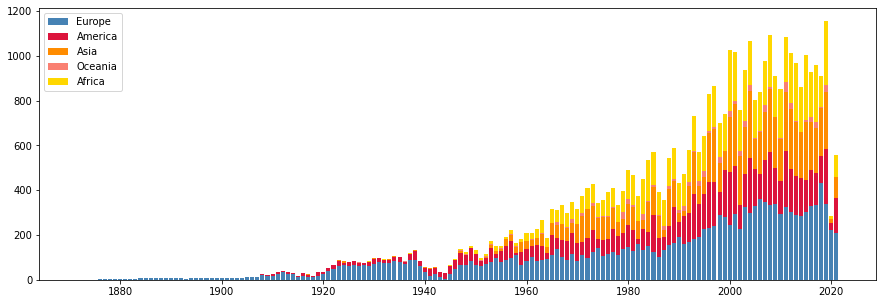

In [155]:
fig, ax = plt.subplots(figsize=(15,5))
plt.bar(years, europe.matches.values, color='steelblue')
plt.bar(years, america.matches.values, bottom=europe.matches.values , color='crimson')
plt.bar(years, asia.matches.values, bottom = europe.matches.values+america.matches.values, color='darkorange')
plt.bar(years, oceania.matches.values, bottom = europe.matches.values+america.matches.values+asia.matches.values , color='salmon')
plt.bar(years, africa.matches.values, bottom=europe.matches.values + america.matches.values + asia.matches.values + oceania.matches.values, color='gold')
plt.legend(['Europe', 'America', 'Asia', 'Oceania', 'Africa'])

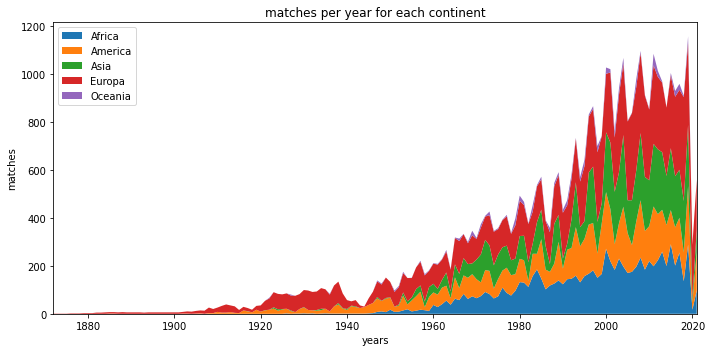

In [154]:

fig, ax = plt.subplots(figsize=(10, 5))
ax.stackplot(years, africa.matches.values, america.matches.values, asia.matches.values, europe.matches.values, oceania.matches.values, labels=['Africa', 'America', 'Asia', 'Europa', 'Oceania'])
ax.set_title('matches per year for each continent')
ax.legend(loc='upper left')
ax.set_ylabel('matches')
ax.set_xlabel('years')
ax.set_xlim(xmin=years[0], xmax=years[-1])
fig.tight_layout()

##### Numero di squadre per continente

In [46]:
dst = pd.read_csv('dataset/dataset_continent.csv')
dst.drop(labels=['Unnamed: 0'], axis=1, inplace=True)

dst_ = dst.copy()

home_teams = dst.groupby('home_team', as_index=False).max()
home_teams = home_teams['home_team'].values


away_teams = dst_.groupby('away_team', as_index=False).max()
away_teams = away_teams['away_team'].values


print(home_teams.__len__() , away_teams.__len__(), type(away_teams))

teams = np.concatenate((home_teams, away_teams))

print(home_teams.__len__() , away_teams.__len__())




print(away_teams)
print(home_teams)

# dst.head()

308 306 <class 'numpy.ndarray'>
308 306 Åland Islands
['Abkhazia' 'Afghanistan' 'Albania' 'Alderney' 'Algeria' 'American Samoa'
 'Andalusia' 'Andorra' 'Angola' 'Anguilla' 'Antigua and Barbuda'
 'Arameans Suryoye' 'Argentina' 'Armenia' 'Artsakh' 'Aruba' 'Asturias'
 'Australia' 'Austria' 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Barawa' 'Barbados' 'Basque Country' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bermuda' 'Bhutan' 'Bolivia' 'Bonaire' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'British Virgin Islands' 'Brittany' 'Brunei'
 'Bulgaria' 'Burkina Faso' 'Burma' 'Burundi' 'Cambodia' 'Cameroon'
 'Canada' 'Cape Verde' 'Cascadia' 'Catalonia' 'Cayman Islands'
 'Central African Republic' 'Central Spain' 'Chad' 'Chagos Islands'
 'Chameria' 'Chile' 'China PR' 'Colombia' 'Comoros' 'Congo' 'Cook Islands'
 'Corsica' 'Costa Rica' 'County of Nice' 'Crimea' 'Croatia' 'Cuba'
 'Curaçao' 'Cyprus' 'Czech Republic' 'Czechoslovakia' 'DR Congo' 'Darfur'
 'Denmark' 'Djibouti' 'Dominica' 'Dominican Rep

##### Numero di goal per anno -- TO DO

In [45]:
years = dst['year'].drop_duplicates().to_numpy()

# years

df = pd.DataFrame(data={
                    'year': years,
                    'n_matches': np.zeros(len(years), dtype=float),
                    # home goals
                    'hg': np.zeros(len(years), dtype=float),
                    # away goals
                    'ag': np.zeros(len(years), dtype=float),
                    # total goals
                    'tot': np.zeros(len(years), dtype=float)
                    })


for i in years:
    df.at[ df['year'] == i, 'n_matches'] = dst[dst['year'] == i].home_score.__len__()
    df.at[ df['year'] == i, 'hg'] = dst[dst['year'] == i].home_score.sum()
    df.at[ df['year'] == i, 'ag'] = dst[dst['year'] == i].away_score.sum()
    df.at[ df['year'] == i, 'tot'] = dst[dst['year'] == i].home_score.sum() + dst[dst['year'] == i].away_score.sum()

df.head()

,year,n_matches,hg,ag,tot
0,1872,1.0,0.0,0.0,0.0
1,1873,1.0,4.0,2.0,6.0
2,1874,1.0,2.0,1.0,3.0
3,1875,1.0,2.0,2.0,4.0
4,1876,2.0,7.0,0.0,7.0


##### Numero di vittorie per continente -- TO DO

### Decision-Trees

Riduco la dimensionalità del dataset per semplicità

In [2]:
from sklearn.model_selection import train_test_split

dst = pd.read_csv('dataset/dataset.csv')
dst.drop(labels=['Unnamed: 0', 'city', 'country', 'tournament', 'day', 'month'], axis=1, inplace=True)
dst = dst[dst['year'] >= 2010]
dst = dst.reset_index().drop(labels=['index'], axis=1)

np.random.seed(1346)

dst_training, dst_test = train_test_split(dst,test_size=0.15)

len(dst)
dst

ModuleNotFoundError: No module named 'sklearn'

In [20]:
!pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=6dcc0ea2086061b6744ee3df5b10065afc9e9782c039c9323e2c908ab97d4068
  Stored in directory: /Users/danilo/Library/Caches/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn
